In [1]:
import os

import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import urllib.request
import seaborn as sns
import plotly.express as px
import folium
from random import sample
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#importation des données:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocalisation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

### Fichier 

In [3]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [4]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [5]:
order_payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [6]:
order_reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

Merge par 'order_id'

In [7]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

Merge par 'customer_id'

In [8]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

Merge par 'product_id'

In [9]:
translation.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

Merge par 'product_category_name'

In [10]:
sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

Merge par 'seller_id'

In [11]:
geolocalisation.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

Merge par 'geolocation_zip_code_prefix' et customer_zip_code_prefix

Pas de lien avec des Data pour Sellers et Geolocalisation

### Merge

In [12]:
data = pd.merge(orders, order_items, on="order_id")

In [13]:
data = pd.merge(data, order_payments, on="order_id")

In [14]:
data = pd.merge(data, order_reviews, on="order_id")

In [15]:
data = pd.merge(data, customers, on="customer_id")

In [16]:
data = pd.merge(data, products, on="product_id")

In [17]:
data = pd.merge(data, translation , on="product_category_name")

In [18]:
data = pd.merge(data, sellers , on="seller_id")

In [19]:
geo_aggregated = geolocalisation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
}).reset_index()


Moyennes des lat et lng car plusieurs données pour un seul code postal, cela ajouter des lignes à la DF merge final

In [20]:
data = pd.merge(data, geo_aggregated , 
                       left_on='customer_zip_code_prefix', 
                       right_on='geolocation_zip_code_prefix', 
                       how='left')

Suppression des valeurs dupliquées par rapport aux commandes, cette valeur doit être unique. L'index est réinitialisé.

### Exploration

In [21]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'geolocation_zip_code_prefix',
       'geolocation_la

In [22]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP,47813.0,-12.177924,-44.660711
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,24.0,19.0,21.0,auto,14840,guariba,SP,75265.0,-16.745150,-48.514783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,40.0,10.0,40.0,baby,17602,tupa,SP,11722.0,-24.001500,-46.449864
115605,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1,b80910977a37536adeddd63663f916ad,...,32.0,90.0,22.0,home_appliances_2,8290,sao paulo,SP,45920.0,-17.898358,-39.373630
115606,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574
115607,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2,d1c427060a0f73f6b889a5c7c61f2ac4,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574


In [23]:
data.describe()

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115299.000000,115299.000000,115299.000000
mean,1.194535,120.619850,20.056880,1.093747,2.946233,172.387379,4.034409,35061.537597,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,24515.713958,34984.829695,-21.234484,-46.196654
std,0.685926,182.653476,15.836184,0.729849,2.781087,265.873969,1.385584,29841.671732,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,27636.640968,29828.821758,5.563683,4.043692
min,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,1003.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1003.000000,-33.689948,-72.668881
25%,1.000000,39.900000,13.080000,1.000000,1.000000,60.870000,4.000000,11310.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,11250.000000,-23.590298,-48.104959
50%,1.000000,74.900000,16.320000,1.000000,2.000000,108.050000,5.000000,24241.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,24230.000000,-22.928999,-46.631777
75%,1.000000,134.900000,21.210000,1.000000,4.000000,189.480000,5.000000,58745.000000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28605.000000,58300.500000,-20.182732,-43.622642
max,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,99980.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99980.000000,42.184003,-8.723762


In [24]:
data.isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000121
order_delivered_carrier_date     0.010337
order_delivered_customer_date    0.020760
order_estimated_delivery_date    0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_id                        0.000000
review_score                     0.000000
review_comment_title             0.880623
review_comment_message           0.576971
review_creation_date             0.000000
review_answer_timestamp          0

Je regarde les deux variables qui m'ont l'air similaire

In [25]:
selected_columns = ['customer_unique_id', 'customer_id']
data_selected = data[selected_columns]

print(data_selected)

                      customer_unique_id                       customer_id
0       7c396fd4830fd04220f754e42b4e5bff  9ef432eb6251297304e76186b10a928d
1       7c396fd4830fd04220f754e42b4e5bff  9ef432eb6251297304e76186b10a928d
2       7c396fd4830fd04220f754e42b4e5bff  9ef432eb6251297304e76186b10a928d
3       af07308b275d755c9edb36a90c618231  b0830fb4747a6c6d20dea0b8c802d7ef
4       3a653a41f6f9fc3d2a113cf8398680e8  41ce2a54c0b03bf3443c3d931a367089
...                                  ...                               ...
115604  da62f9e57a76d978d02ab5362c509660  1fca14ff2861355f6e5f14306ff977a7
115605  737520a9aad80b3fbbdad19b66b37b30  1aa71eb042121263aafbe80c1b562c9c
115606  5097a5312c8b157bb7be58ae360ef43c  b331b74b18dc79bcdf6532d51e1637c1
115607  5097a5312c8b157bb7be58ae360ef43c  b331b74b18dc79bcdf6532d51e1637c1
115608  60350aa974b26ff12caad89e55993bd6  edb027a75a1449115f6b43211ae02a24

[115609 rows x 2 columns]


In [26]:
data[['customer_unique_id', 'customer_id']].nunique()

customer_unique_id    93396
customer_id           96516
dtype: int64

Elles ne sont pas similaires

In [27]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data['order_delivered_carrier_date'] = pd.to_datetime(data['order_delivered_carrier_date'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

Traitement des valeurs manquantes

In [28]:
tx_remplissage = 1 - data.isna().sum()/len(data)
tx_remplissage = pd.DataFrame(tx_remplissage)
tx_remplissage = tx_remplissage.transpose()
tx_remplissage

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1.0,1.0,1.0,1.0,0.999879,0.989663,0.97924,1.0,1.0,1.0,...,0.999991,0.999991,0.999991,1.0,1.0,1.0,1.0,0.997319,0.997319,0.997319


### Suppresion variable inutile

In [29]:
colonnes_a_supprimer = ['order_approved_at','order_delivered_carrier_date','shipping_limit_date','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp','product_name_lenght','product_photos_qty','product_description_lenght','product_category_name']
data = data.drop(columns=(colonnes_a_supprimer))

In [30]:
data.shape

(115609, 32)

Suppresion des données manquantes de géolocalisation

In [31]:
data = data.dropna(subset=['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'])

In [32]:
data.isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_delivered_customer_date    0.020703
order_estimated_delivery_date    0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_id                        0.000000
review_score                     0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
product_weight_g                 0.000009
product_length_cm                0.000009
product_height_cm                0

In [33]:
data = data.dropna(subset=['product_width_cm', 'product_height_cm', 'product_length_cm','product_weight_g'])

In [34]:
data.shape

(115298, 32)

In [35]:
data.drop_duplicates()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,...,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP,47813.0,-12.177924,-44.660711
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,...,24.0,19.0,21.0,auto,14840,guariba,SP,75265.0,-16.745150,-48.514783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,174.90,...,40.0,10.0,40.0,baby,17602,tupa,SP,11722.0,-24.001500,-46.449864
115605,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,205.99,...,32.0,90.0,22.0,home_appliances_2,8290,sao paulo,SP,45920.0,-17.898358,-39.373630
115606,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574
115607,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574


### Analyse

In [36]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,...,19.0,8.0,13.0,housewares,9350,maua,SP,3149.0,-23.576983,-46.587161
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,...,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP,47813.0,-12.177924,-44.660711
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,...,24.0,19.0,21.0,auto,14840,guariba,SP,75265.0,-16.745150,-48.514783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,174.90,...,40.0,10.0,40.0,baby,17602,tupa,SP,11722.0,-24.001500,-46.449864
115605,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,205.99,...,32.0,90.0,22.0,home_appliances_2,8290,sao paulo,SP,45920.0,-17.898358,-39.373630
115606,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574
115607,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,179.99,...,20.0,20.0,20.0,computers_accessories,37175,ilicinea,MG,28685.0,-22.562825,-42.694574


In [37]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [38]:
data.describe()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,115298,112911,115298,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000,115298.000000
mean,2017-12-31 04:10:14.659291648,2018-01-13 16:40:00.467412224,2018-01-24 00:48:13.288695296,1.194652,120.590263,20.050492,1.093913,2.945637,172.339616,4.034363,34984.351151,2114.823952,30.311749,16.641858,23.116333,24526.443416,34984.351151,-21.234407,-46.196610
min,2016-09-04 21:15:19,2016-10-11 13:46:32,2016-10-20 00:00:00,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,1003.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1003.000000,-33.689948,-72.668881
25%,2017-09-12 11:16:12.249999872,2017-09-25 18:14:12.500000,2017-10-03 00:00:00,1.000000,39.900000,13.080000,1.000000,1.000000,60.860000,4.000000,11250.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,11250.000000,-23.590286,-48.104959
50%,2018-01-19 01:01:48,2018-02-02 00:55:36,2018-02-15 00:00:00,1.000000,74.900000,16.320000,1.000000,2.000000,108.055000,5.000000,24230.000000,700.000000,25.000000,13.000000,20.000000,13690.000000,24230.000000,-22.928999,-46.631777
75%,2018-05-04 16:04:30,2018-05-15 19:42:57,2018-05-28 00:00:00,1.000000,134.900000,21.200000,1.000000,4.000000,189.390000,5.000000,58299.250000,1800.000000,38.000000,20.000000,30.000000,28615.000000,58299.250000,-20.182732,-43.622642
max,2018-09-03 09:06:57,2018-10-17 13:22:46,2018-10-25 00:00:00,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,99980.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99980.000000,42.184003,-8.723762
std,NaN,NaN,NaN,0.686291,182.614742,15.839881,0.730768,2.780942,265.907300,1.385577,29828.508517,3783.162929,16.210564,13.475759,11.754681,27645.694940,29828.508517,5.563647,4.043682


### Analyse univariée

In [39]:
ville = ['customer_zip_code_prefix','customer_city','seller_zip_code_prefix','seller_city','geolocation_zip_code_prefix']
ville_afficher = data[ville]
ville_afficher

,customer_zip_code_prefix,customer_city,seller_zip_code_prefix,seller_city,geolocation_zip_code_prefix
0,3149,sao paulo,9350,maua,3149.0
1,3149,sao paulo,9350,maua,3149.0
2,3149,sao paulo,9350,maua,3149.0
3,47813,barreiras,31570,belo horizonte,47813.0
4,75265,vianopolis,14840,guariba,75265.0
...,...,...,...,...,...
115604,11722,praia grande,17602,tupa,11722.0
115605,45920,nova vicosa,8290,sao paulo,45920.0
115606,28685,japuiba,37175,ilicinea,28685.0
115607,28685,japuiba,37175,ilicinea,28685.0


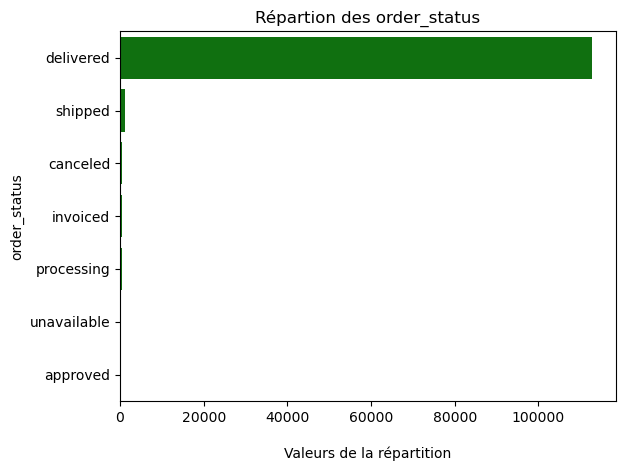

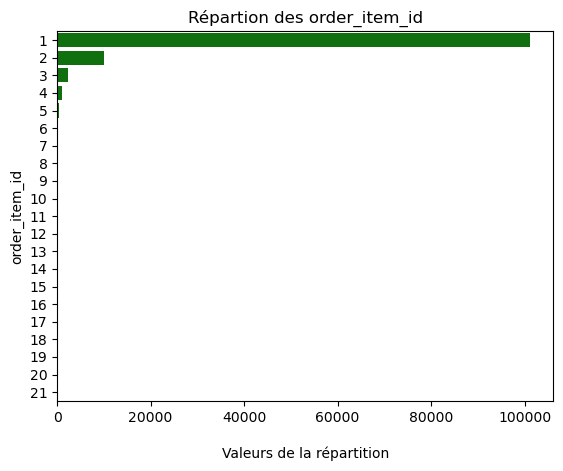

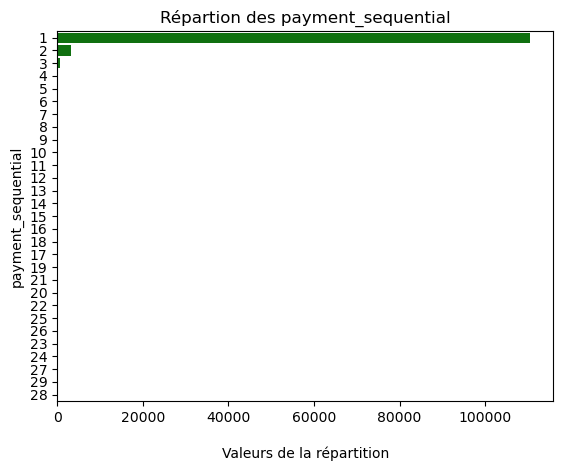

In [40]:
num = ["order_status", "order_item_id", "payment_sequential"]

for cols in num :
    sns.countplot(data=data, y=cols, order=data[cols].value_counts().index, color = 'green')
    plt.xlabel('\nValeurs de la répartition')
    plt.ylabel(cols)
    plt.title("Répartion des "+cols)
    plt.show()

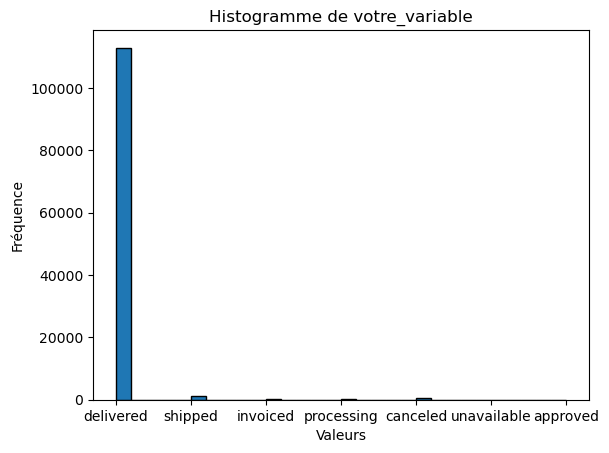

In [41]:
plt.hist(data['order_status'], bins=30, edgecolor='k')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Histogramme de votre_variable')
plt.show()

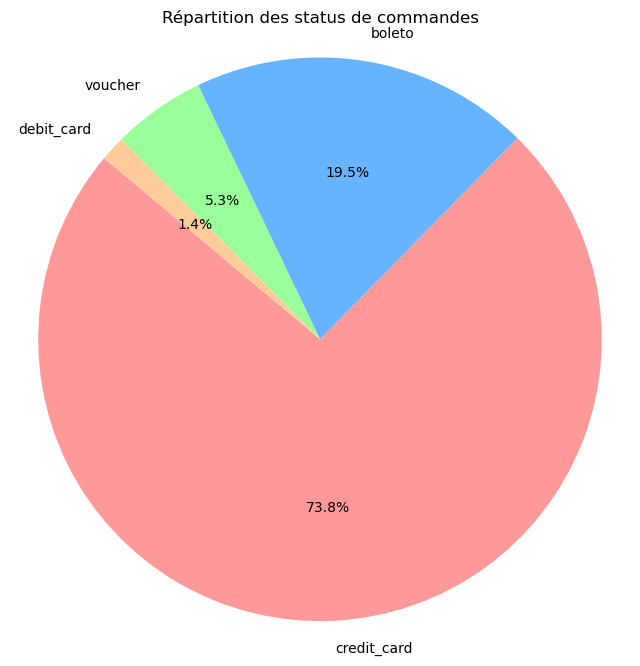

In [42]:
counts = data['payment_type'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Répartition des status de commandes')
plt.axis('equal') 
plt.show()

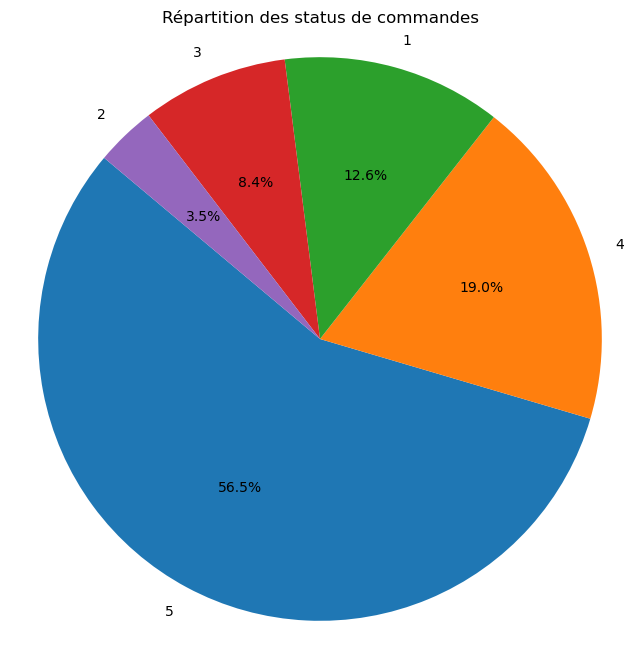

In [43]:
counts = data['review_score'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des status de commandes')
plt.axis('equal') 
plt.show()

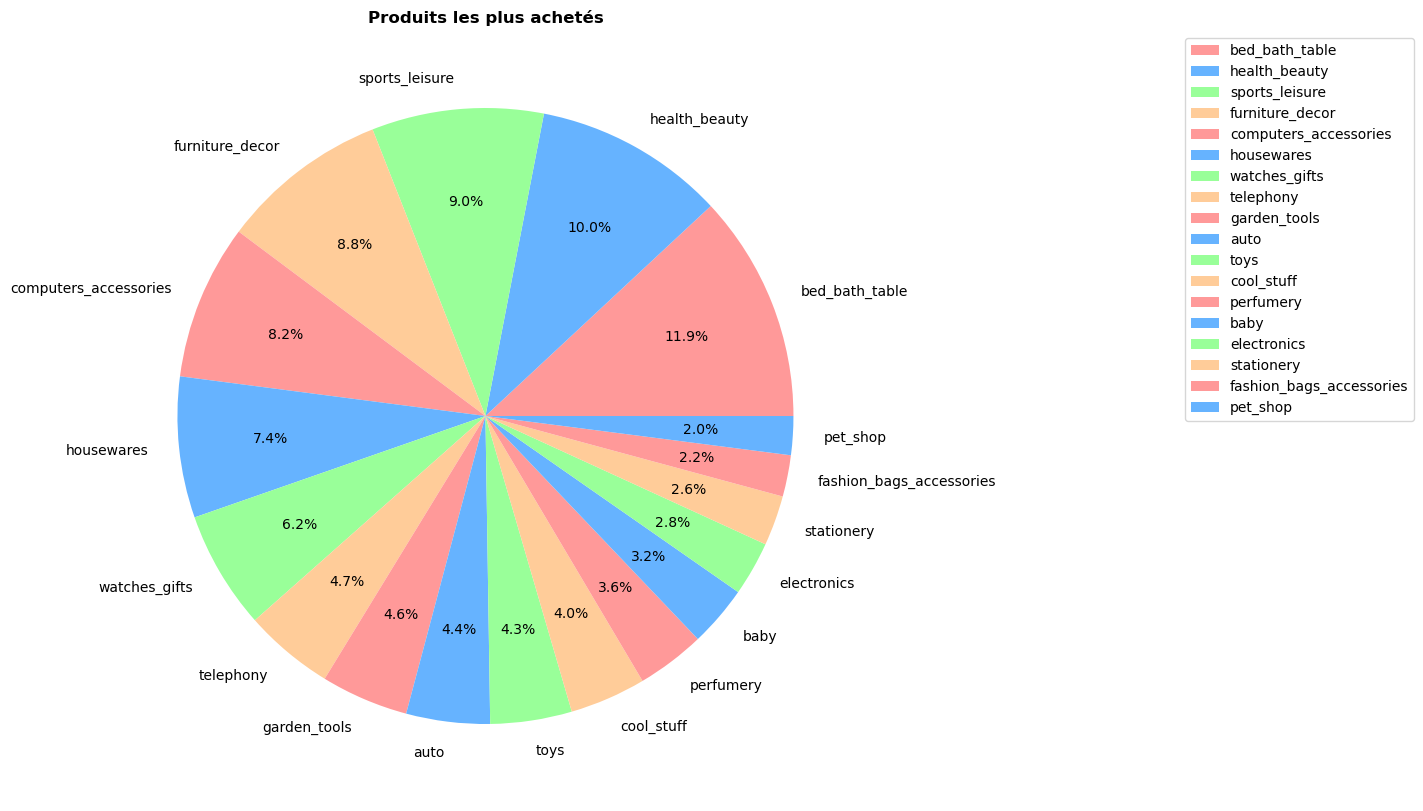

In [44]:
produit = data['product_category_name_english'].value_counts().head(18)

plt.rcParams["figure.figsize"] = (10,10)
plt.pie(produit, labels = produit.index, autopct='%1.1f%%', pctdistance = 0.7, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.legend(bbox_to_anchor=(1.4, 1.0), loc='upper left')
plt.title("Produits les plus achetés", fontsize=12,fontweight = 'bold')
plt.show()

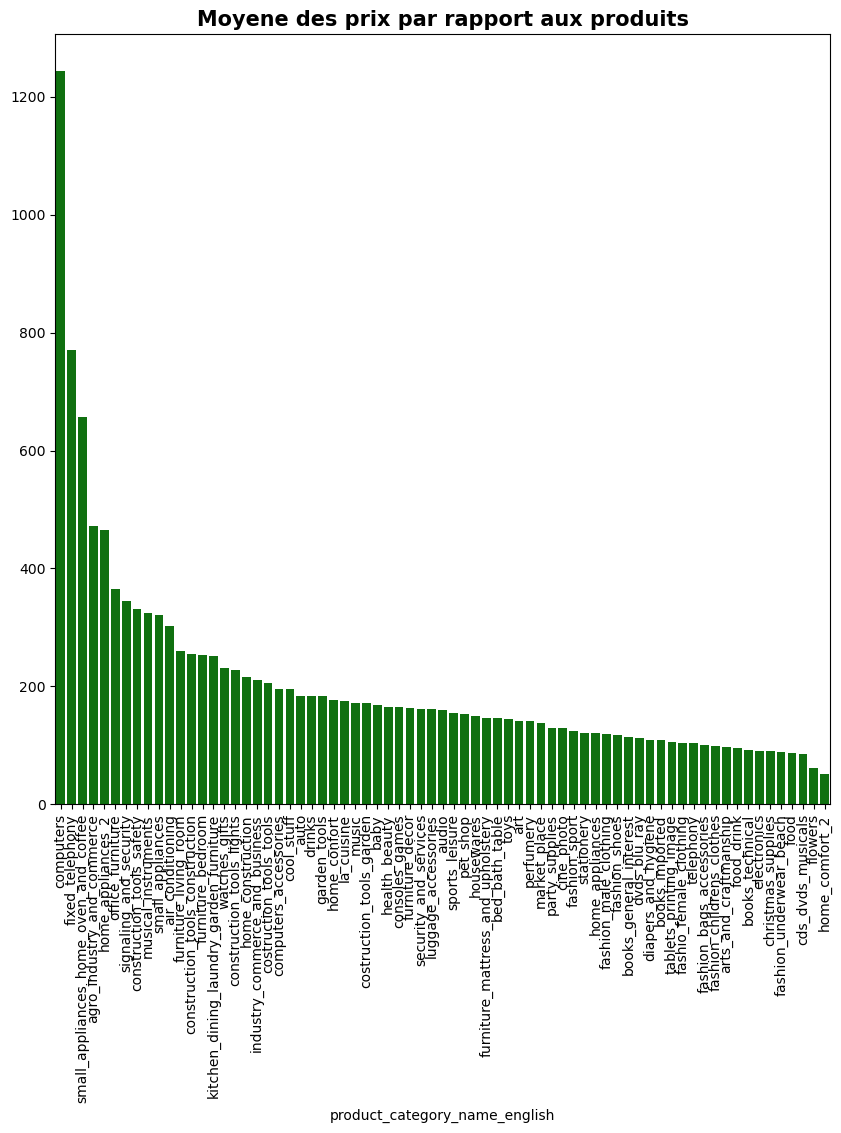

In [45]:
prod_arg = data[["product_category_name_english", 'payment_value']]
prod_arg = prod_arg.groupby('product_category_name_english').mean()
prod_arg = prod_arg.sort_values(by = "payment_value", ascending = False)
prod_arg = prod_arg.transpose()

fig,ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
sns.barplot(data = prod_arg, color = 'green')
ax.tick_params(axis='x', rotation=90)
plt.title("Moyene des prix par rapport aux produits", fontsize=15,fontweight = 'bold')
plt.show()

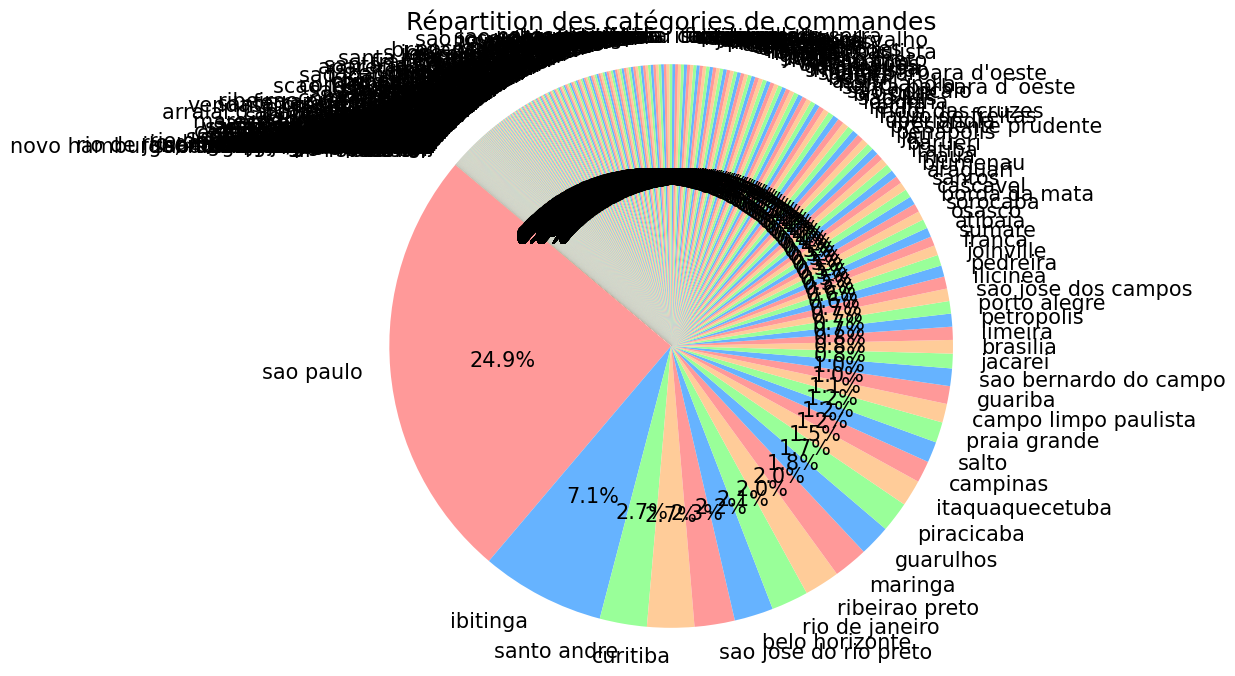

In [46]:
counts = data['seller_city'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Répartition des catégories de commandes')
plt.axis('equal') 
plt.show()

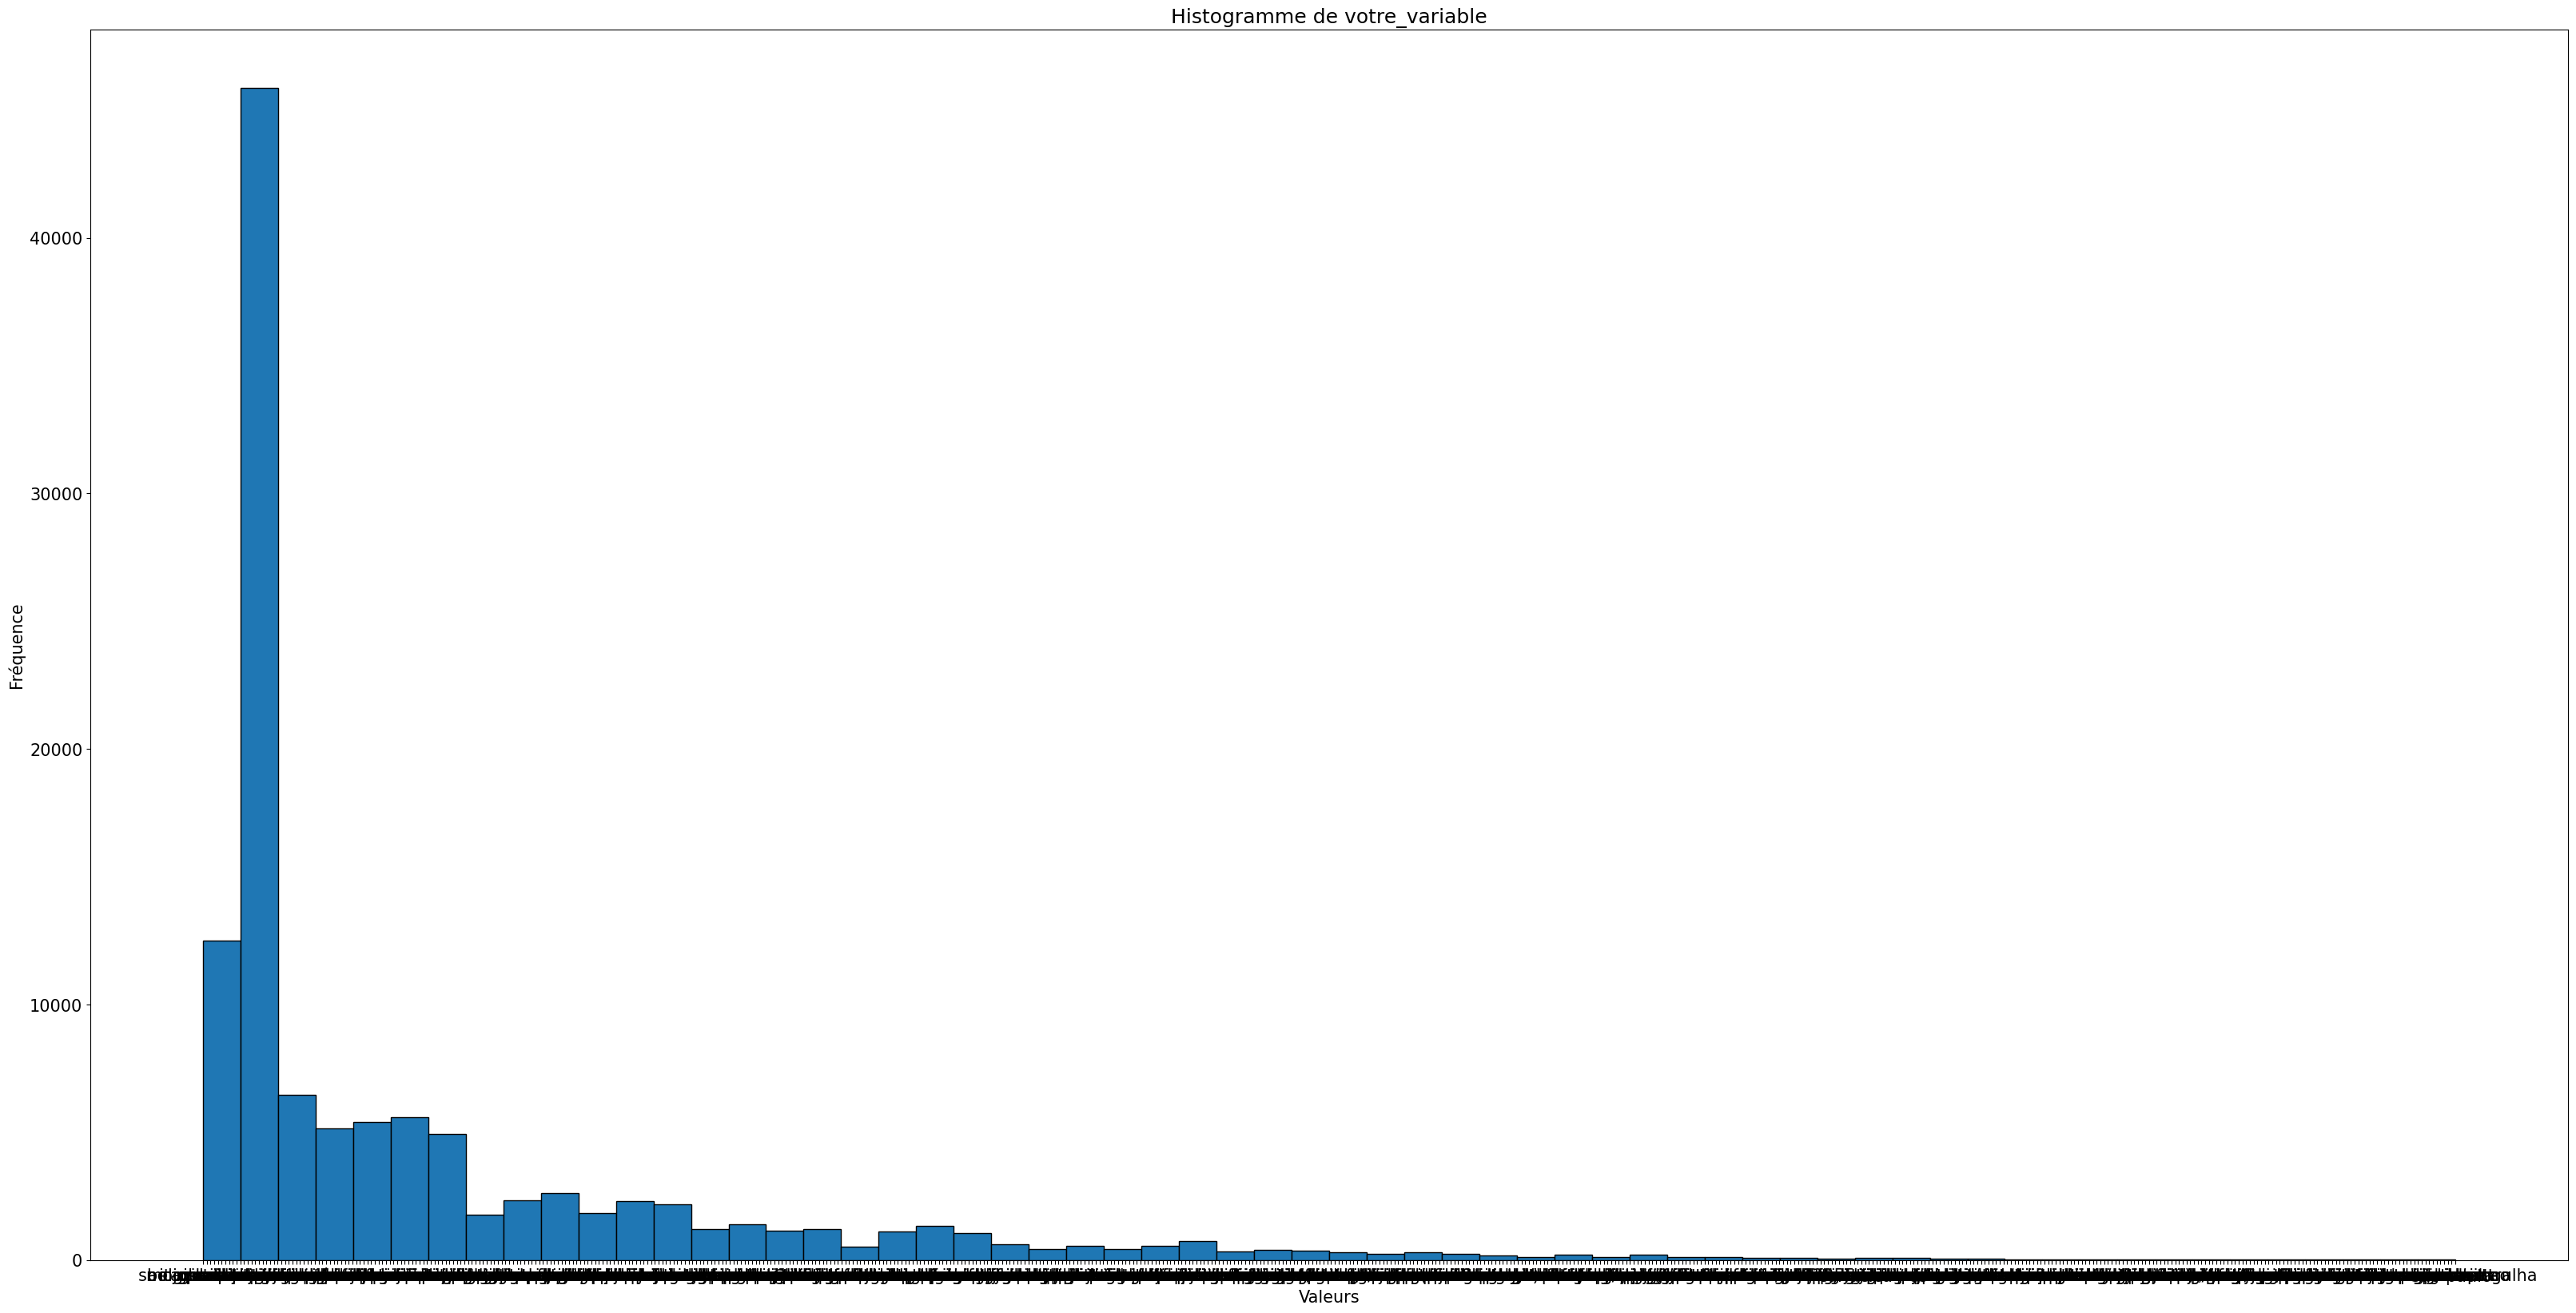

In [47]:
plt.figure(figsize=(40, 20))
plt.hist(data['seller_city'], bins=60, edgecolor='k')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Histogramme de votre_variable')
plt.show()

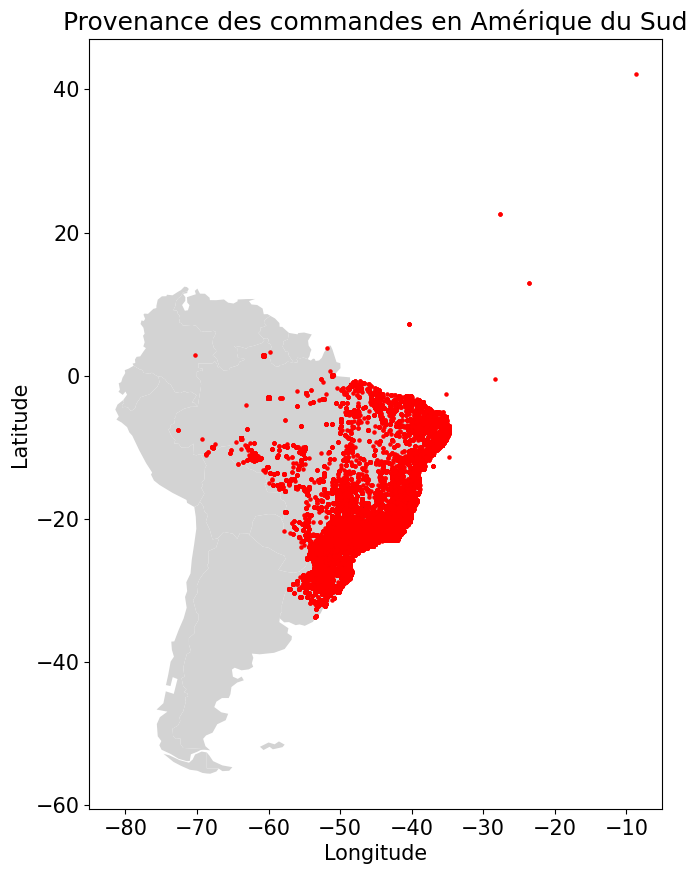

In [48]:
# Créer un GeoDataFrame à partir du DataFrame pandas
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.geolocation_lng, data.geolocation_lat))

# Charger une carte de l'Amérique du Sud
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
south_america = world[(world.continent == 'South America')]

# Plotter la carte
fig, ax = plt.subplots(figsize=(10, 10))
south_america.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=5)

# Ajouter des titres et labels si nécessaire
plt.title('Provenance des commandes en Amérique du Sud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Afficher la carte
plt.show()

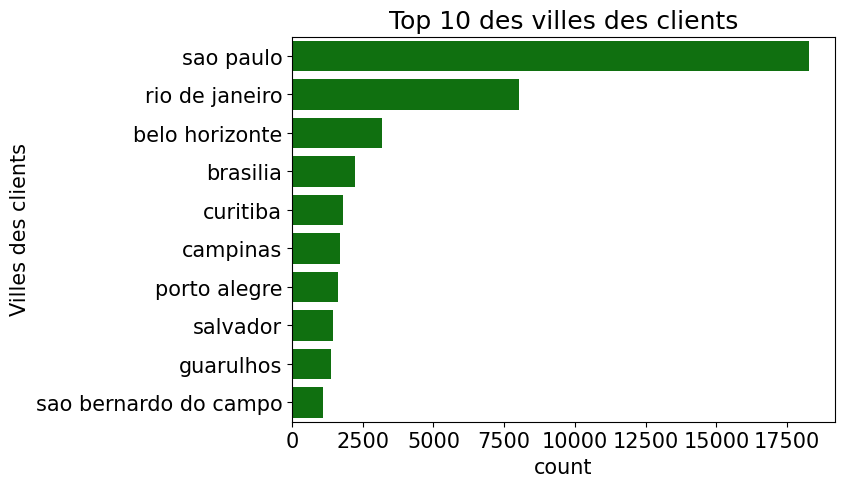

In [49]:
plt.figure(figsize=(7,5))
sns.countplot(y="customer_city", data=data, order=data["customer_city"].value_counts().index[:10], color = 'green')
plt.title("Top 10 des villes des clients")
plt.ylabel("Villes des clients")
plt.show()

Text(0.5, 1.0, 'Répartition du prix des commandes')

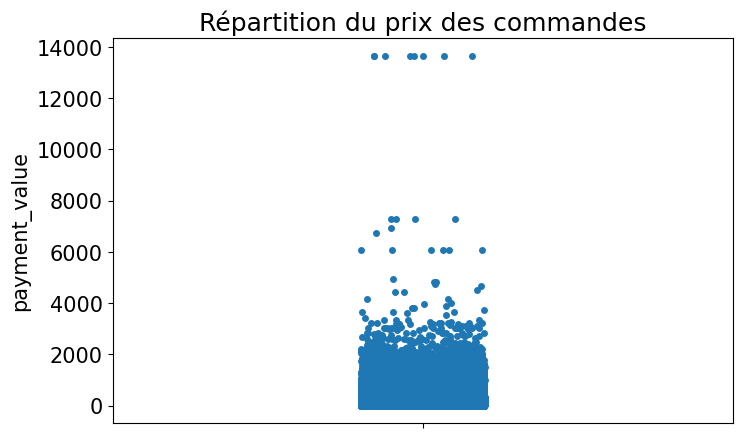

In [50]:
fig, axes = plt.subplots(figsize=(8, 5), sharex=True)
sns.stripplot(data = data["payment_value"])
plt.title("Répartition du prix des commandes")

Text(0.5, 1.0, 'Distribution du prix des commandes')

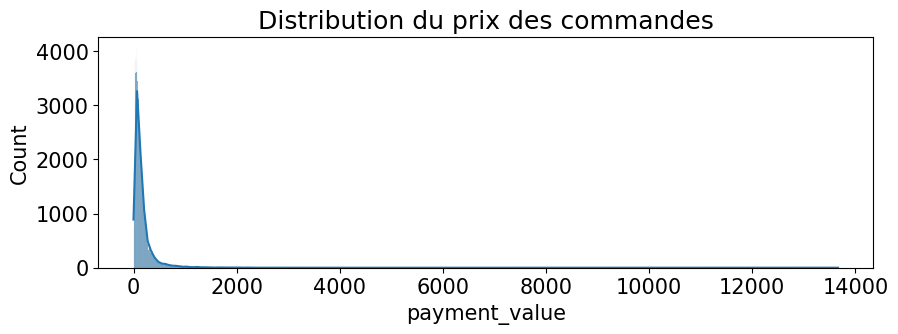

In [51]:
fig, axes = plt.subplots(figsize=(10, 3), sharex=True)
sns.histplot(x="payment_value", data=data, kde=True)
plt.title("Distribution du prix des commandes")

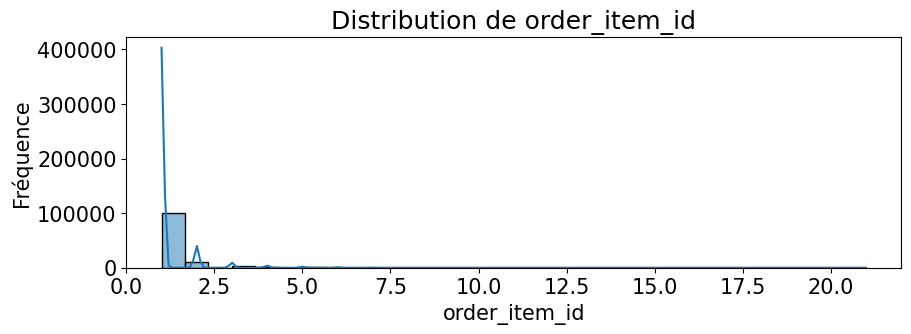

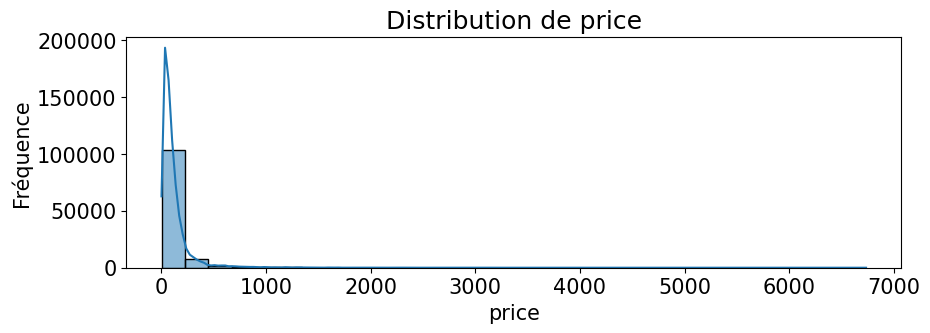

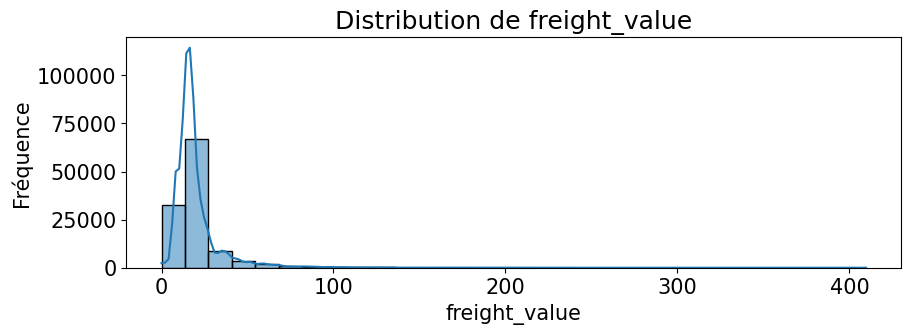

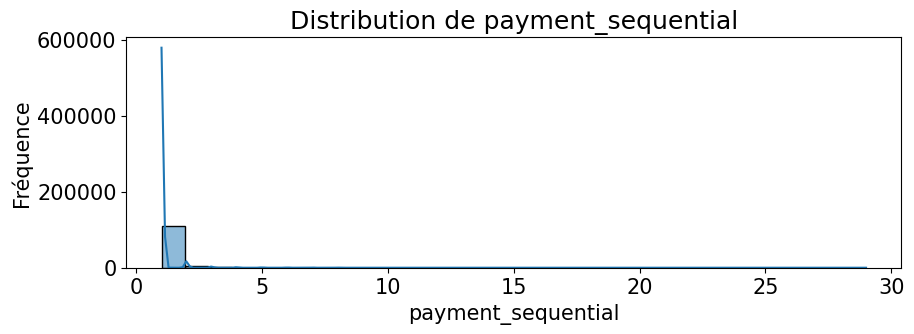

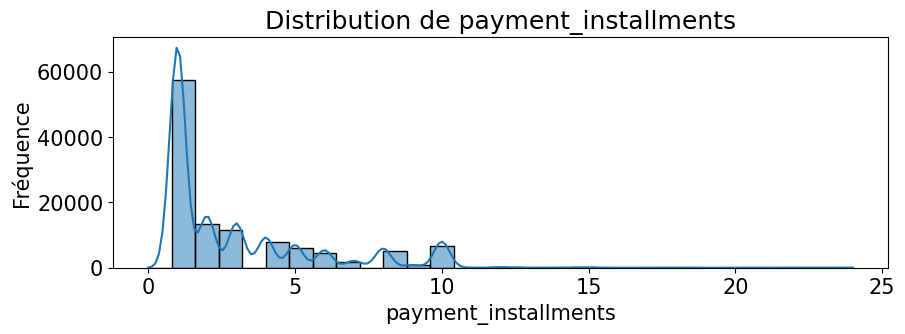

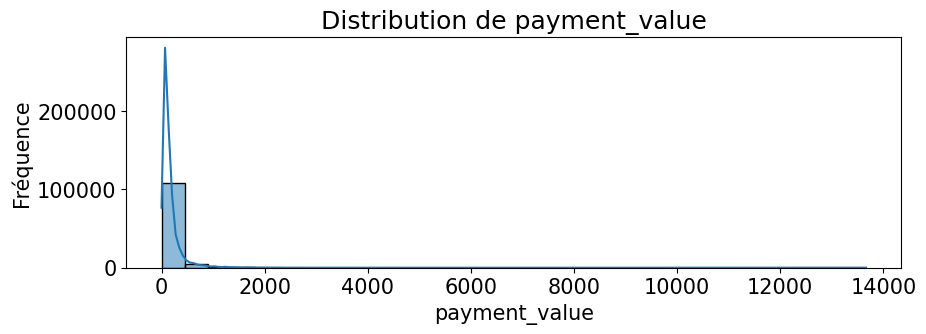

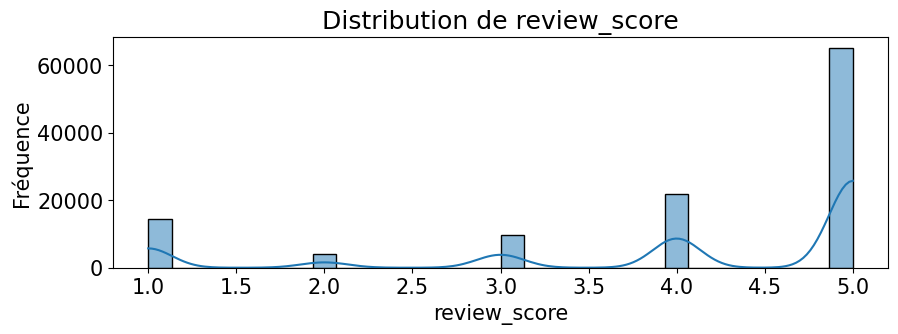

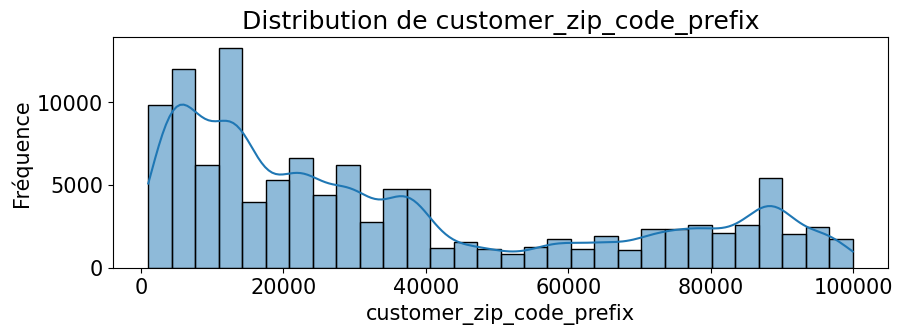

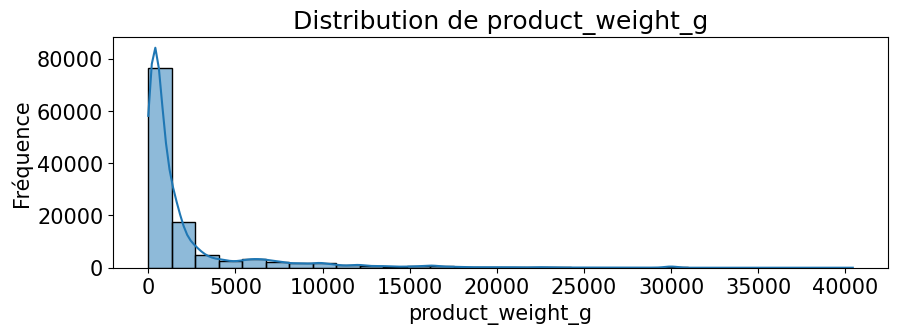

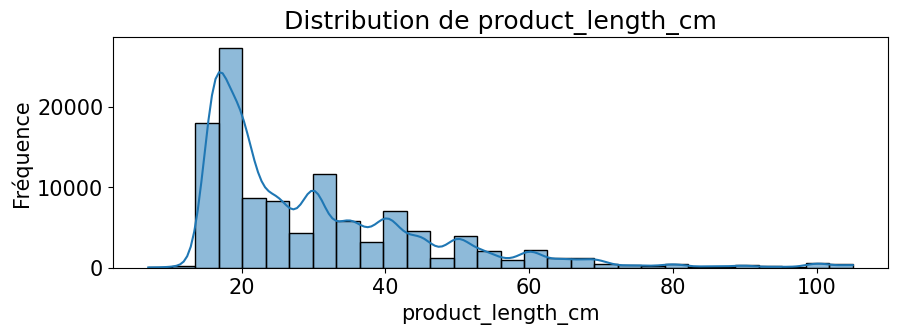

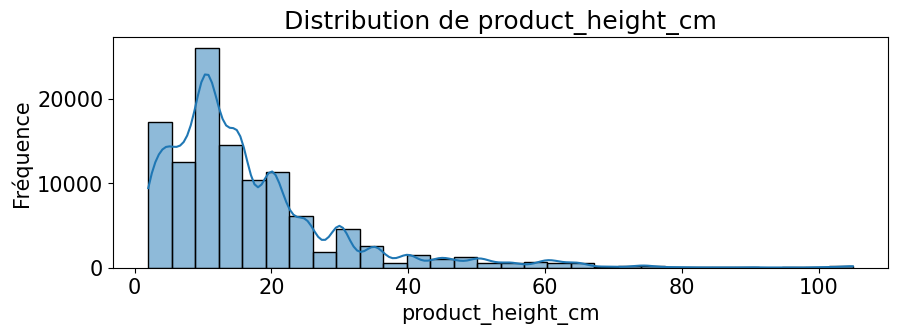

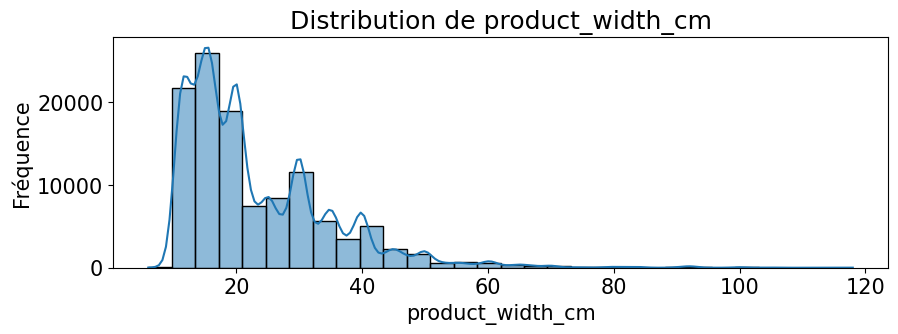

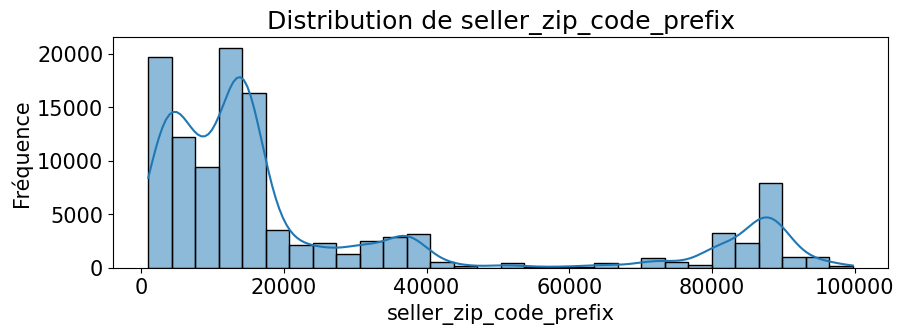

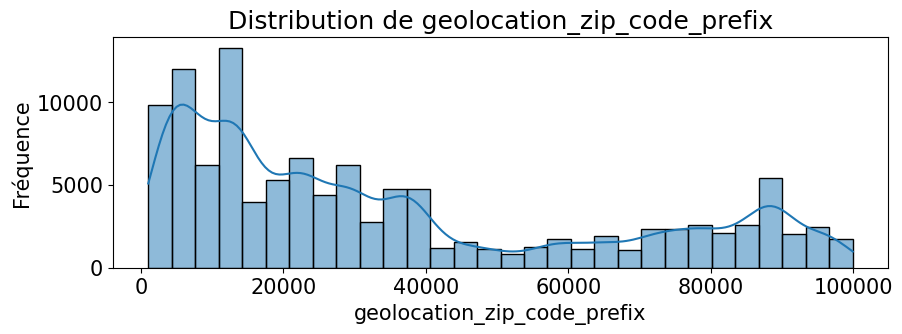

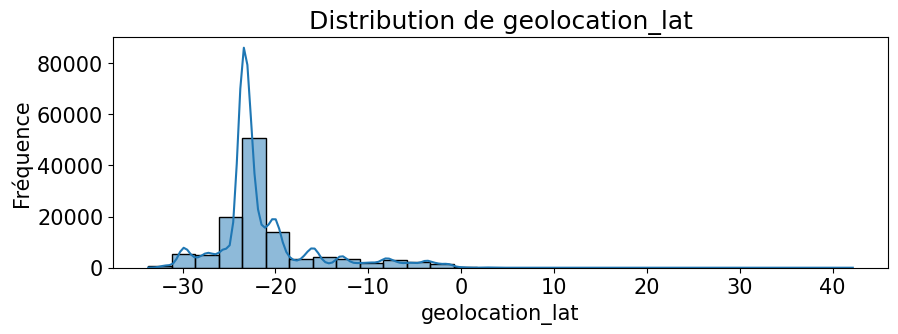

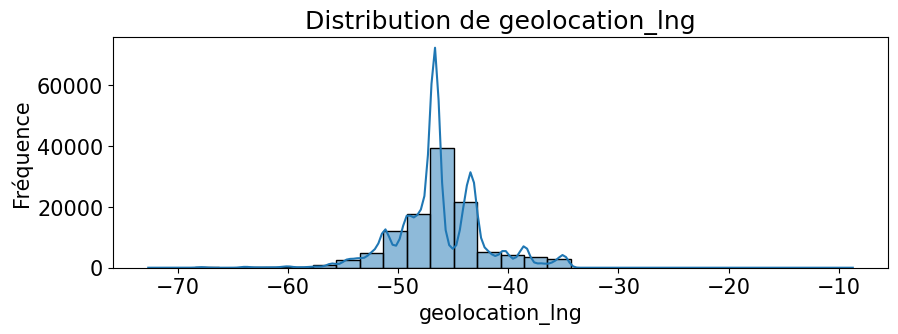

In [52]:
for column in data.select_dtypes(['int64', 'float64']).columns:
    plt.figure(figsize=(10,3))  # Créer une nouvelle figure pour chaque colonne
    sns.histplot(data[column], bins=30, kde=True)  # Utiliser histplot pour les histogrammes
    plt.title('Distribution de ' + str(column))  # Ajouter le titre
    plt.xlabel(column)  # Étiqueter l'axe des x
    plt.ylabel('Fréquence')  # Étiqueter l'axe des y
    plt.show()  # Afficher le graphique

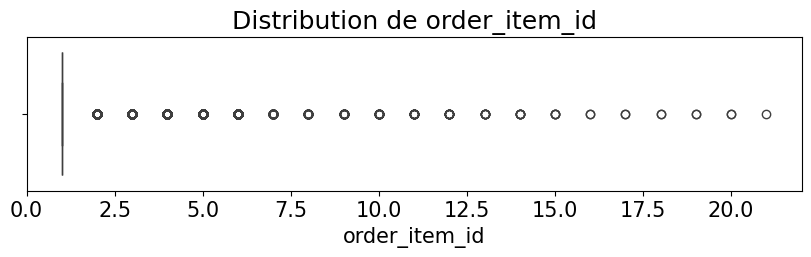

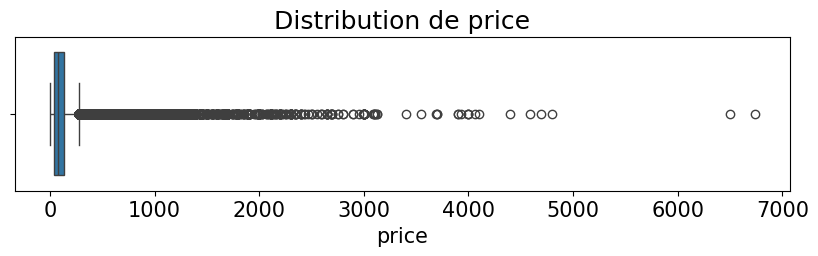

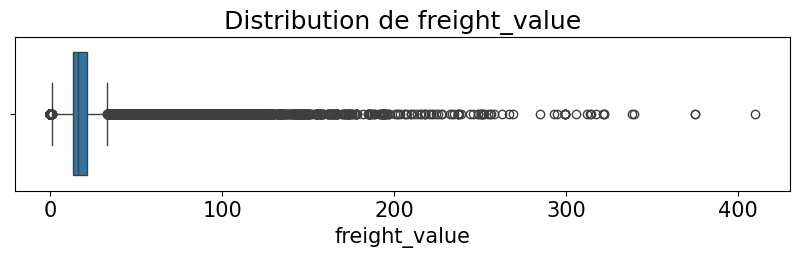

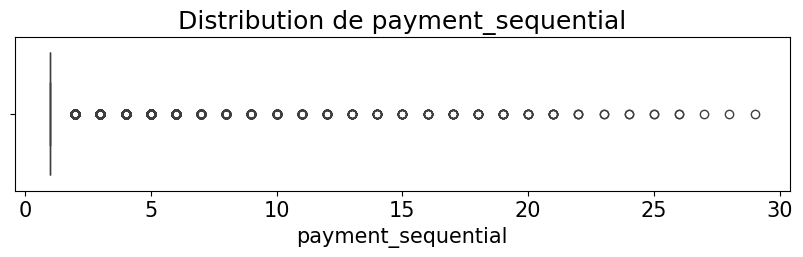

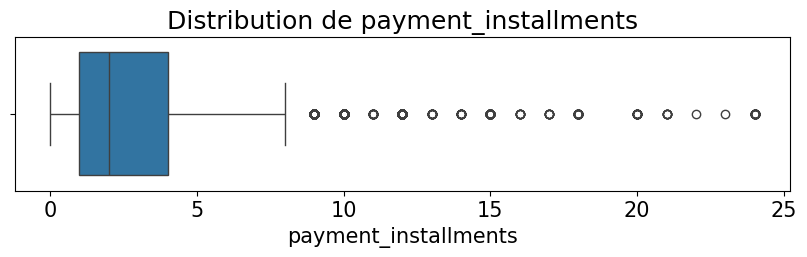

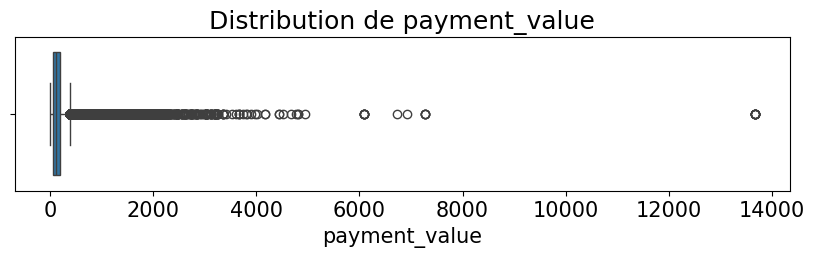

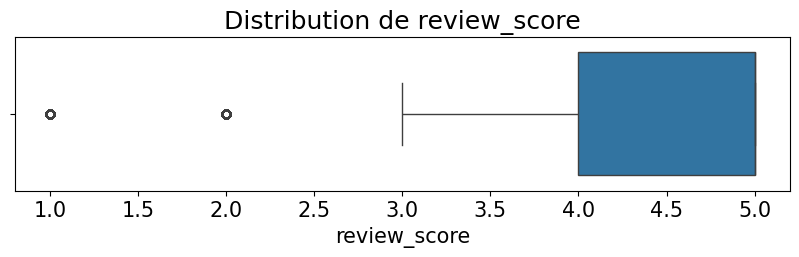

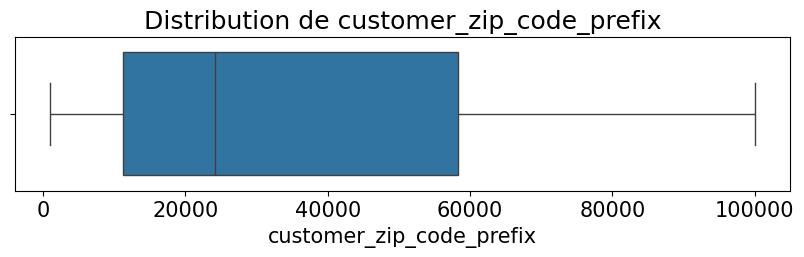

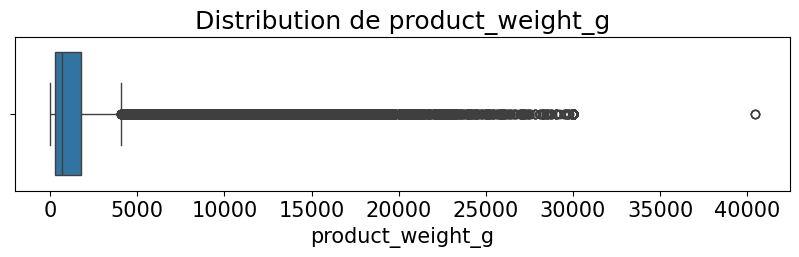

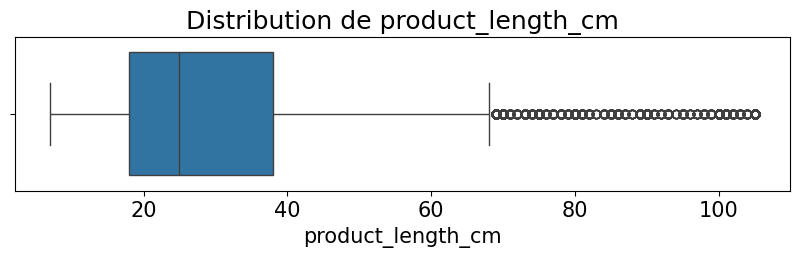

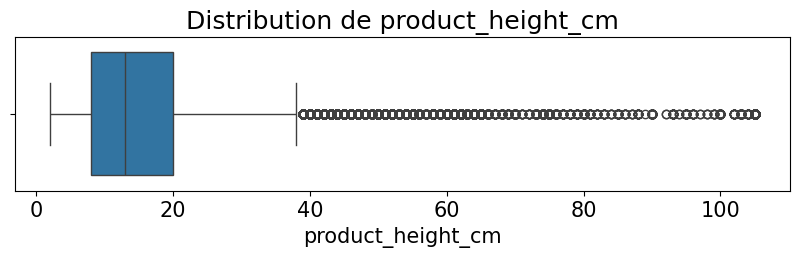

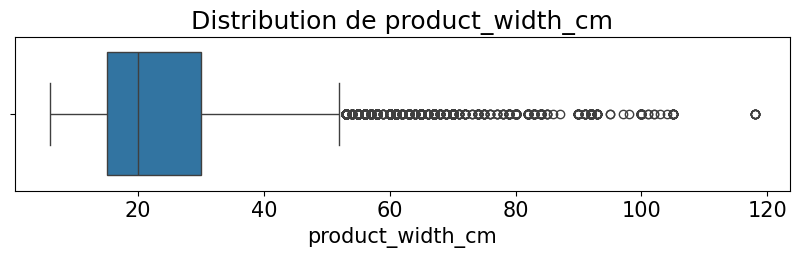

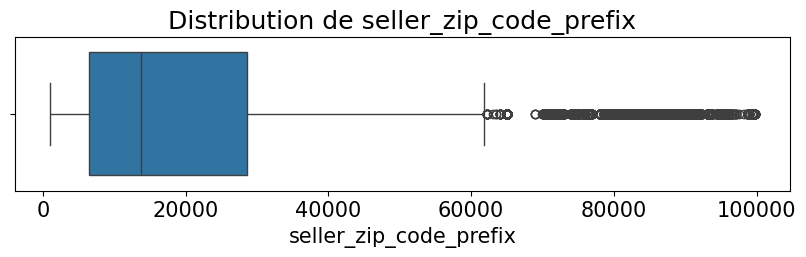

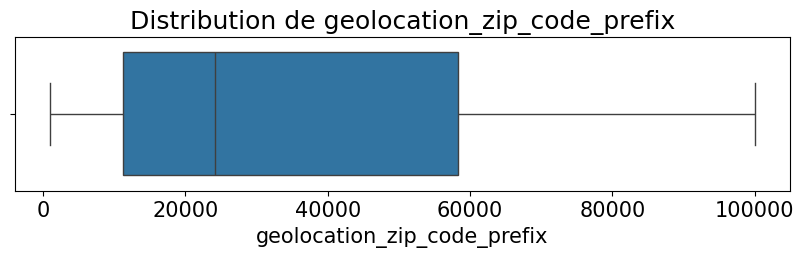

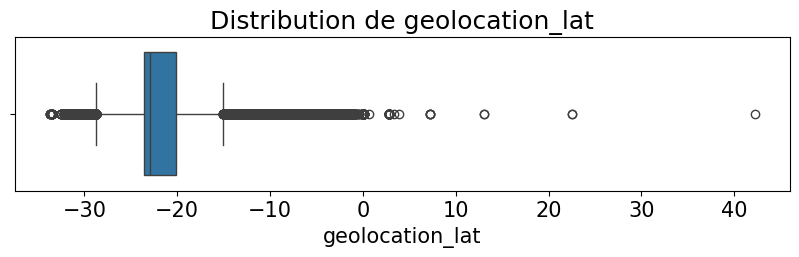

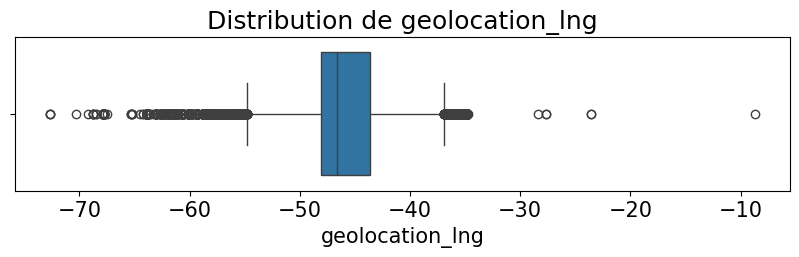

In [53]:
for column in data.select_dtypes(['int64', 'float64']).columns:
    plt.figure(figsize=(10, 2))  # Crée une nouvelle figure pour chaque colonne
    sns.boxplot(x=data[column])  # Utilise boxplot pour tracer le diagramme en boîte
    plt.title('Distribution de ' + str(column))  # Ajoute le titre
    plt.xlabel(column)  # Étiquette de l'axe des x
    plt.show()  # Affiche le graphique

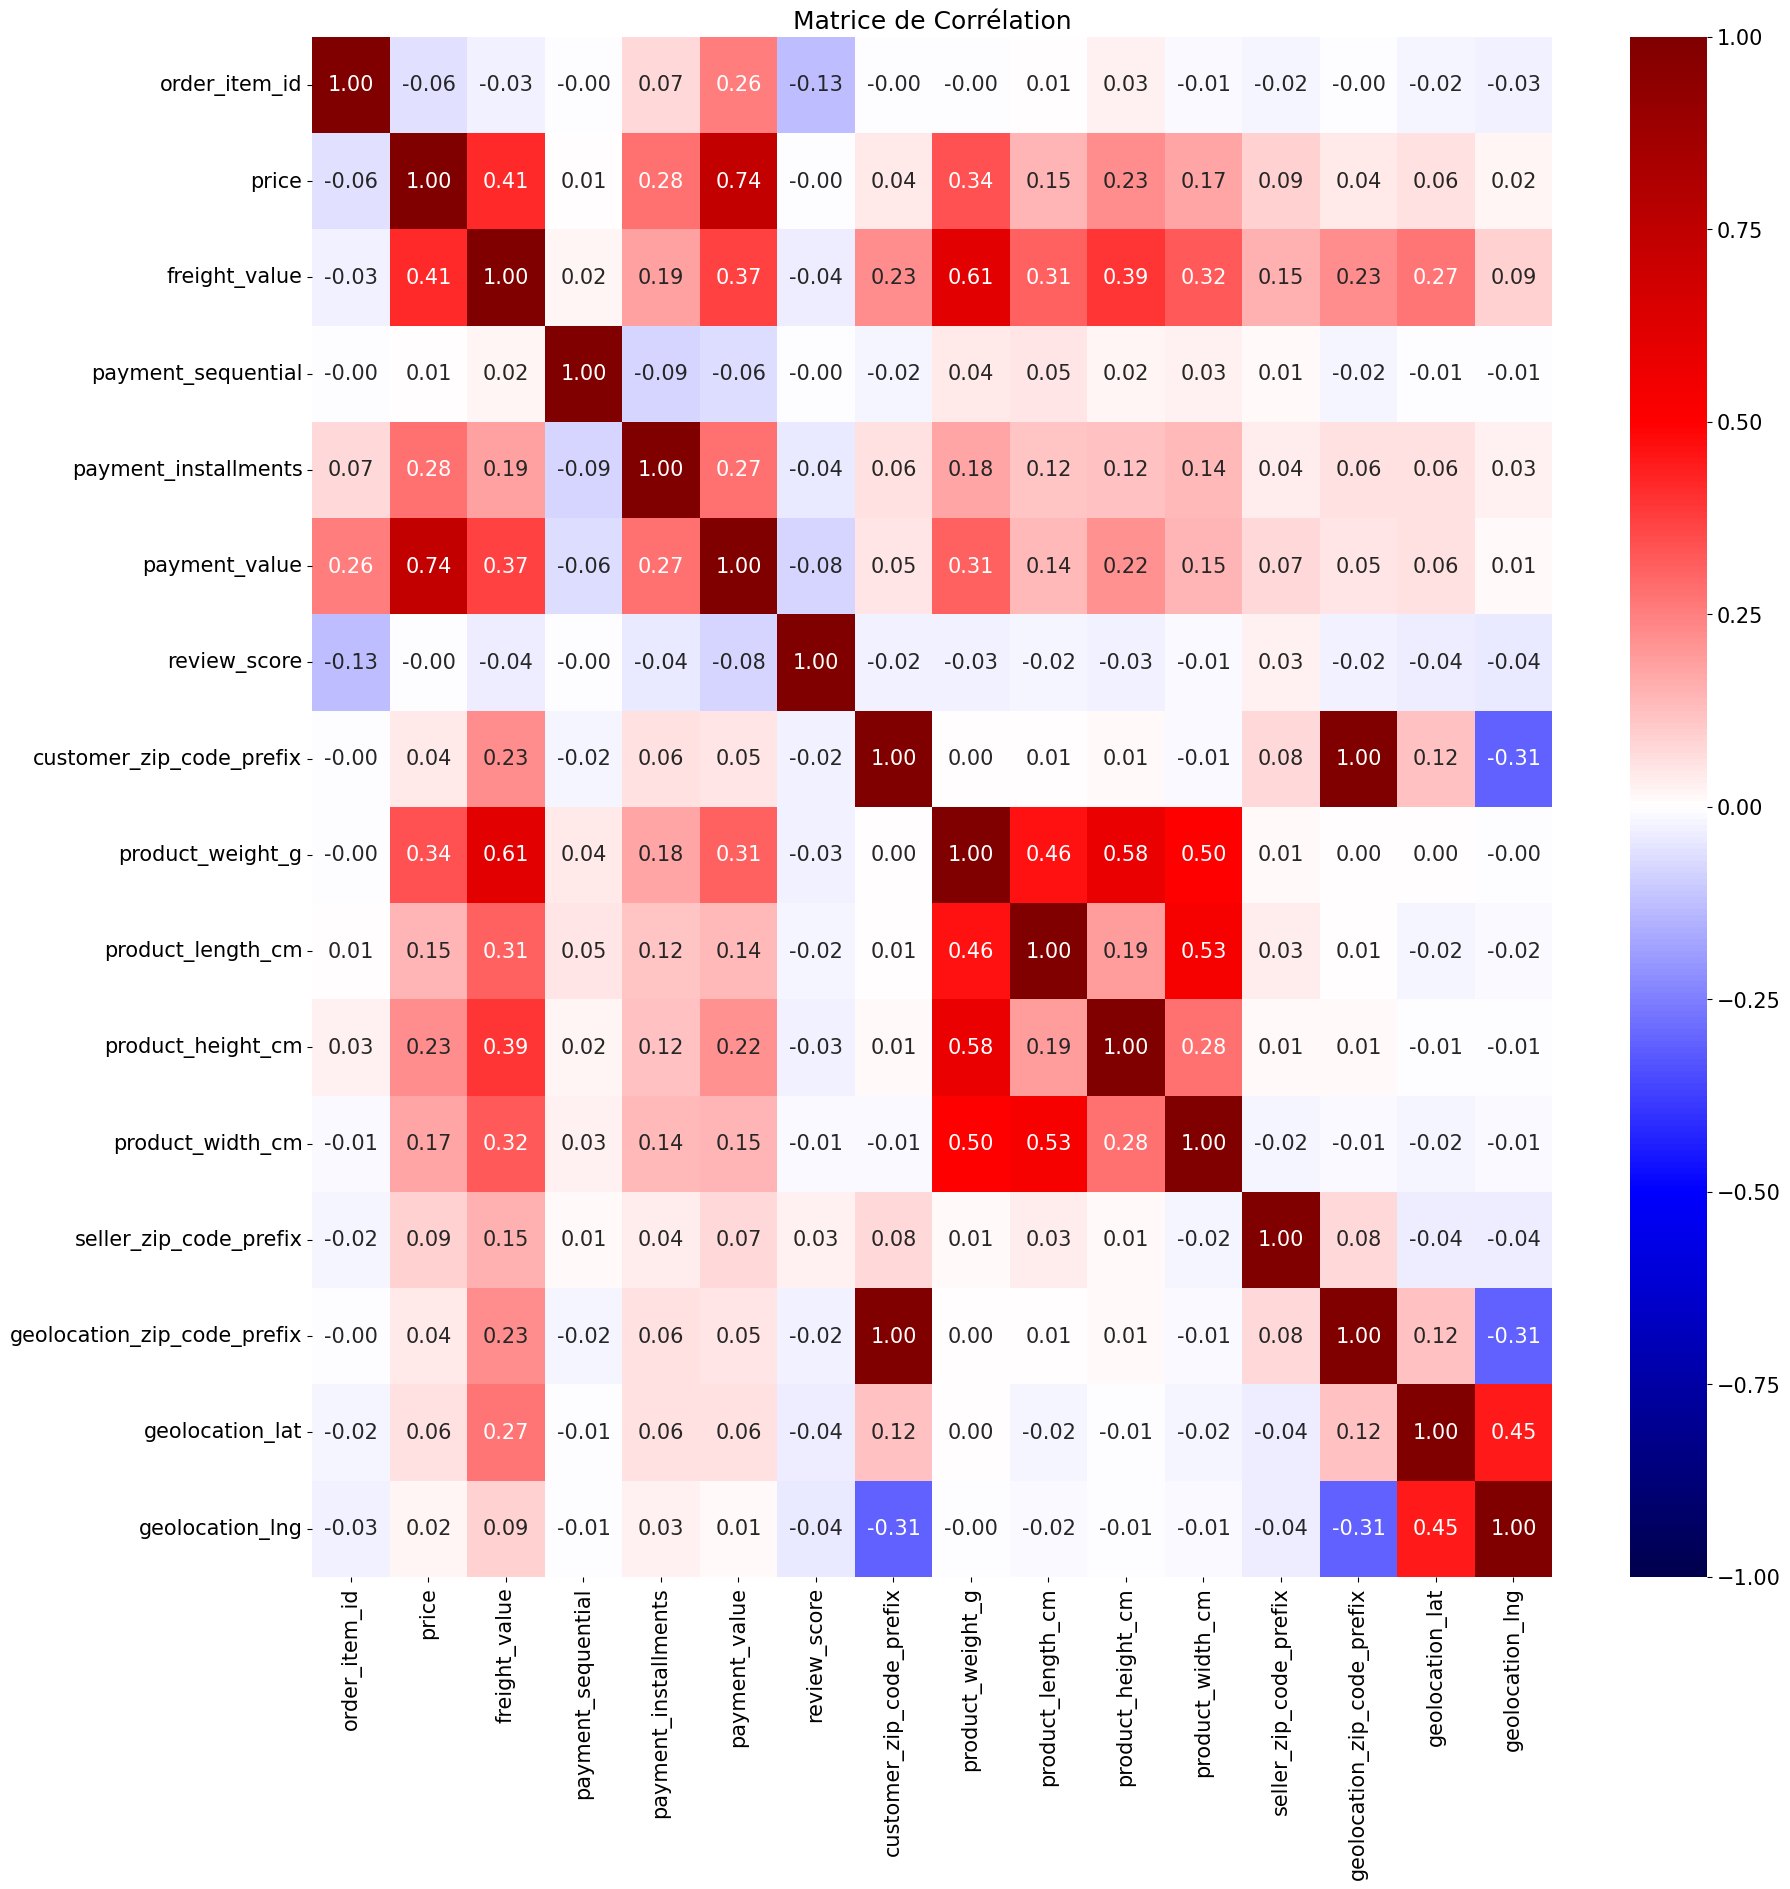

In [54]:
# Sélectionner uniquement les colonnes numériques
data_numeric = data.select_dtypes(include=['int64', 'float64'])

# Calculer la matrice de corrélation
corr_matrix = data_numeric.corr()

# Créer le heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()


In [55]:
date_achat = data[['order_purchase_timestamp']].copy()
date_achat['Année'] = data["order_purchase_timestamp"].dt.year
date_achat['Mois'] = data["order_purchase_timestamp"].dt.month_name()
date_achat['Jour'] = data["order_purchase_timestamp"].dt.day
date_achat['Jour_semaine'] = data["order_purchase_timestamp"].dt.day_name()
date_achat['Heure'] = data["order_purchase_timestamp"].dt.hour
date_achat.head()

,order_purchase_timestamp,Année,Mois,Jour,Jour_semaine,Heure
0,2017-10-02 10:56:33,2017,October,2,Monday,10
1,2017-10-02 10:56:33,2017,October,2,Monday,10
2,2017-10-02 10:56:33,2017,October,2,Monday,10
3,2018-07-24 20:41:37,2018,July,24,Tuesday,20
4,2018-08-08 08:38:49,2018,August,8,Wednesday,8


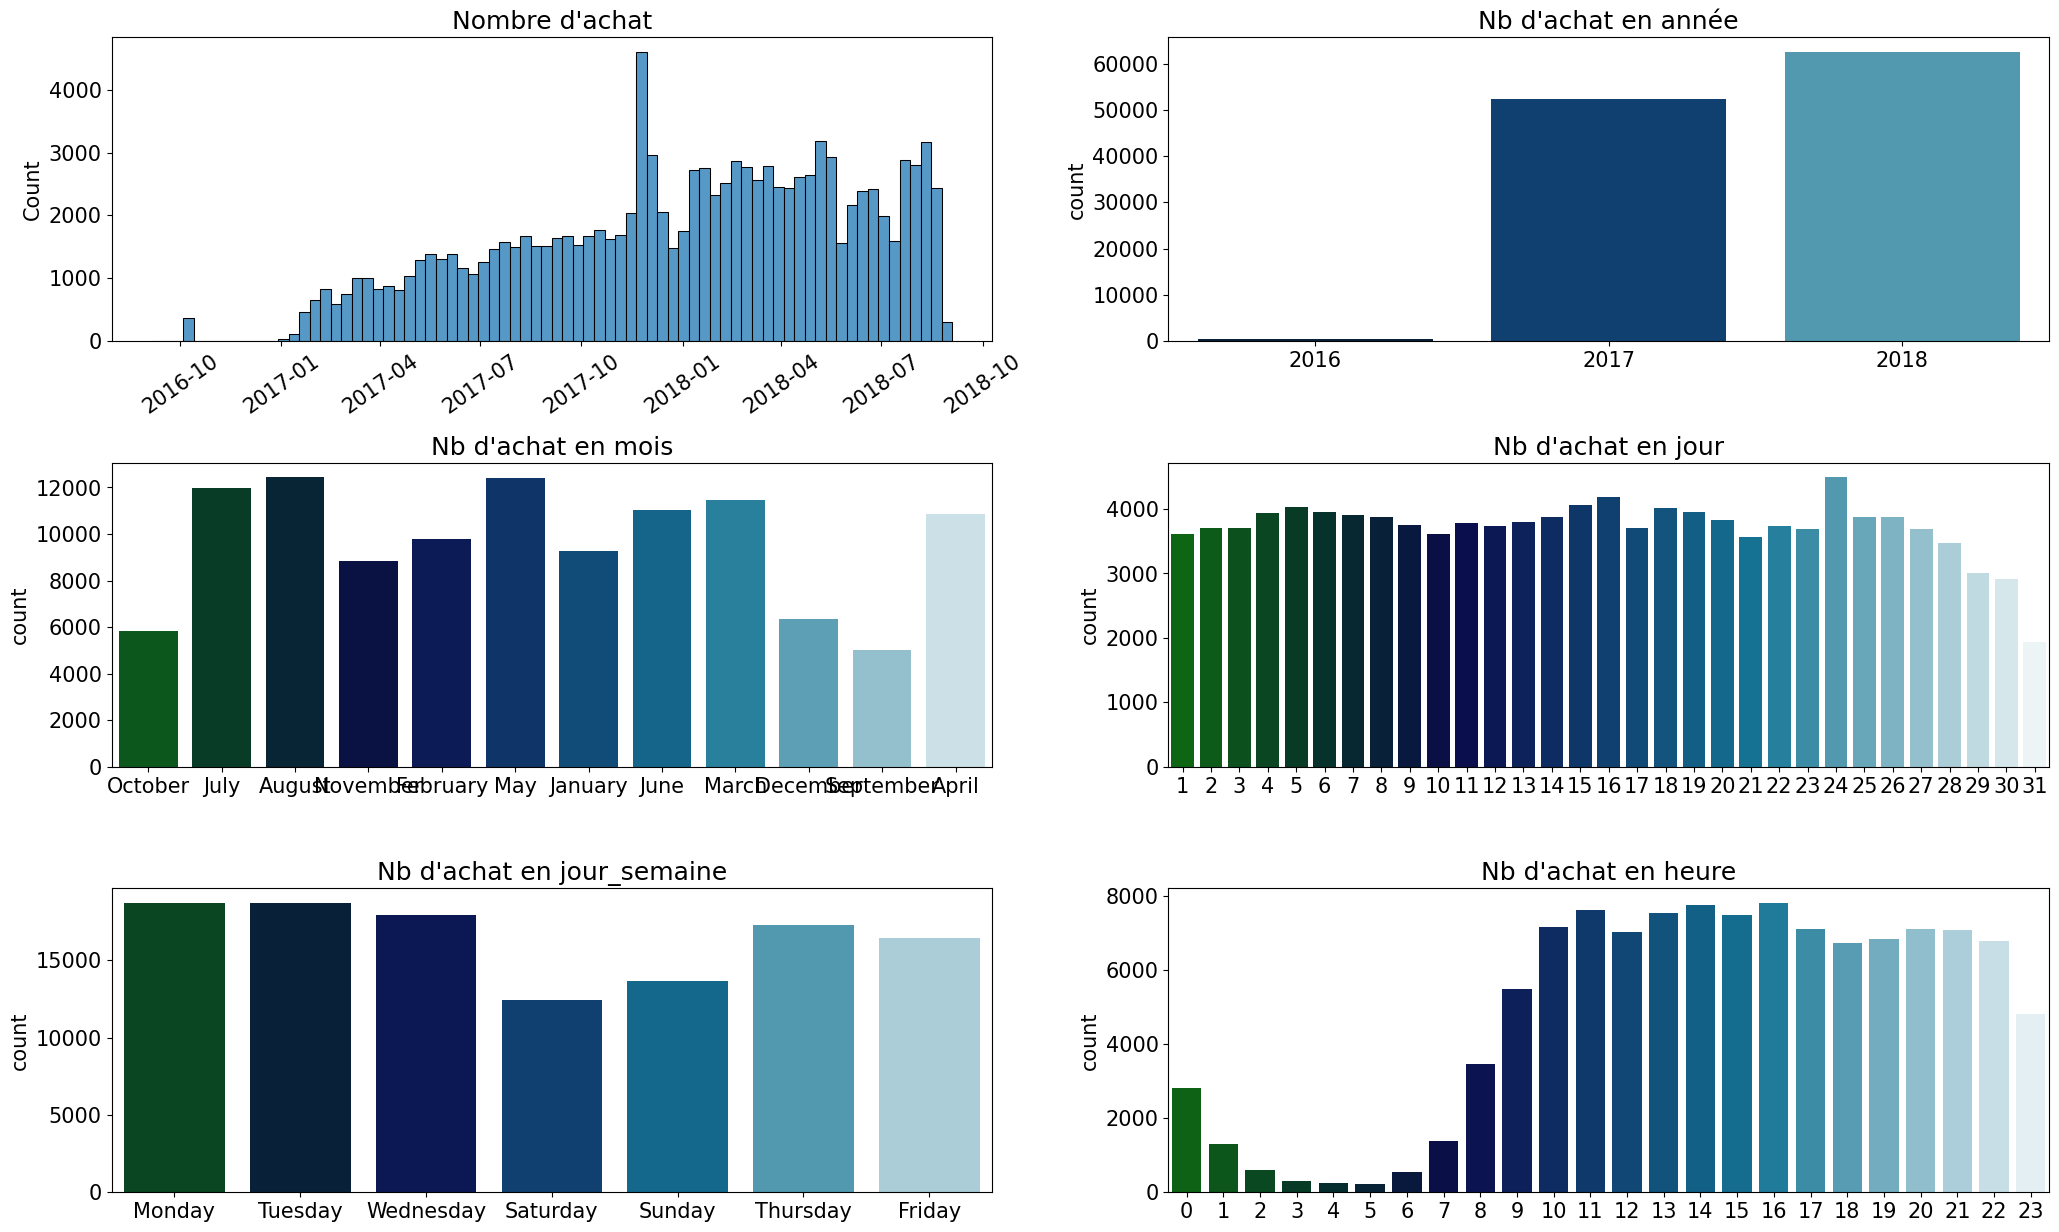

In [56]:
fig, ax = plt.subplots(3,2,figsize=(25,15))
plt.subplots_adjust(hspace=0.4)

sns.histplot(data=date_achat, 
              x="order_purchase_timestamp",
              palette='ocean',
              ax=ax[0,0])
ax[0,0].tick_params(axis='x', labelrotation=35)
ax[0,0].set_title("Nombre d'achat")
ax[0,0].set(xlabel=None)

for k, col in enumerate(date_achat.columns[1:]) :
    i = (k+1)//2
    j = (k+1) % 2
    sns.countplot(data=date_achat, 
                     x=col,
                     palette='ocean',
                     ax=ax[i,j])
    if col == 'Day' :
        ax[i,j].tick_params(axis='x', labelrotation=90) 
    elif col == 'Month' or col == 'Day_name':
            ax[i,j].tick_params(axis='x', labelrotation=35)
    ax[i,j].set_title(f"Nb d'achat en {col.lower()}")
    ax[i,j].set(xlabel=None)
plt.show()

### RFM 3

In [57]:
price = data[['price', 'freight_value','payment_sequential', 'payment_type', 'payment_installments','payment_value']]

In [58]:
price

,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,29.99,8.72,1,credit_card,1,18.12
1,29.99,8.72,3,voucher,1,2.00
2,29.99,8.72,2,voucher,1,18.59
3,118.70,22.76,1,boleto,1,141.46
4,159.90,19.22,1,credit_card,3,179.12
...,...,...,...,...,...,...
115604,174.90,20.10,1,credit_card,3,195.00
115605,205.99,65.02,1,credit_card,5,271.01
115606,179.99,40.59,1,credit_card,4,441.16
115607,179.99,40.59,1,credit_card,4,441.16


In [59]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

Recence

In [60]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
latest_date = data['order_purchase_timestamp'].max()
rfm = data.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days
}).rename(columns={'order_purchase_timestamp': 'Recency'})


Fréquence

In [61]:
frequency = data.groupby('customer_id').agg({
    'order_purchase_timestamp': 'count'
}).rename(columns={'order_purchase_timestamp': 'Frequency'})


Montant

In [62]:
monetary = data.groupby('customer_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).sum(axis=1).rename('Monetary').reset_index()


In [63]:
rfm = rfm.merge(frequency, on='customer_id')
rfm = rfm.merge(monetary, on='customer_id')

In [64]:
rfm

,customer_id,Recency,Frequency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,292,1,114.74
1,000161a058600d5901f007fab4c27140,413,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,551,1,195.42
3,0002414f95344307404f0ace7a26f1d5,382,1,179.35
4,000379cdec625522490c315e70c7a9fb,153,1,107.01
...,...,...,...,...
96243,fffcb937e9dd47a13f05ecb8290f4d3e,170,1,91.91
96244,fffecc9f79fd8c764f843e9951b11341,157,3,244.08
96245,fffeda5b6d849fbd39689bb92087f431,103,1,63.13
96246,ffff42319e9b2d713724ae527742af25,81,1,214.13


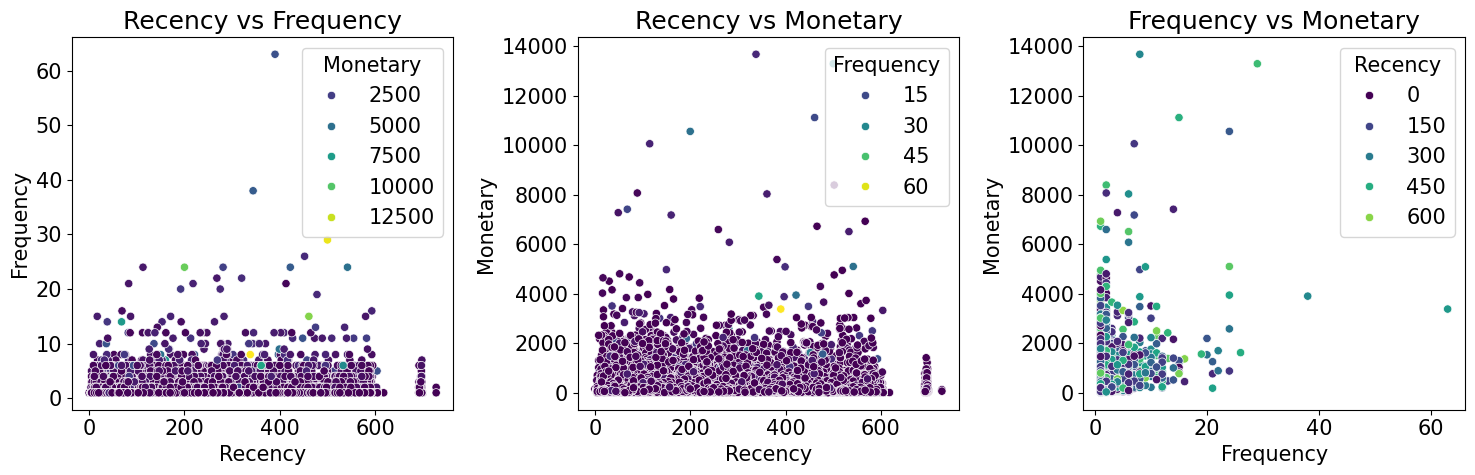

In [65]:
# Plotting
plt.figure(figsize=(15, 5))

# Scatter plot for Recency vs Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Monetary', palette='viridis')
plt.title('Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')

# Scatter plot for Recency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Frequency', palette='viridis')
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')

# Scatter plot for Frequency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Recency', palette='viridis')
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')

plt.tight_layout()
plt.show()

1. Recency vs Frequency
Observations générales : La majorité des points se trouvent dans la partie inférieure gauche du graphique, indiquant une fréquence d'achat faible et une récence d'achat élevée.
Distribution : La fréquence des achats varie principalement entre 0 et 10, avec quelques clients ayant des fréquences d'achat beaucoup plus élevées (jusqu'à 60).
Relation avec la valeur monétaire : Les points de couleur plus claire (indiquant une valeur monétaire plus élevée) sont dispersés de manière aléatoire, suggérant qu'il n'y a pas de corrélation claire entre la récence, la fréquence et la valeur monétaire des achats.
2. Recency vs Monetary
Observations générales : La plupart des clients ont une valeur monétaire d'achat inférieure à 2000.
Distribution : Les valeurs monétaires s'étendent jusqu'à 14 000, mais les valeurs plus élevées sont beaucoup moins fréquentes.
Relation avec la fréquence : Les points de couleur plus claire (indiquant une fréquence plus élevée) sont dispersés dans l'ensemble du graphique, ce qui suggère une faible corrélation entre la récence et la valeur monétaire. Les clients ayant des achats récents ont tendance à avoir une valeur monétaire plus élevée.
3. Frequency vs Monetary
Observations générales : La majorité des clients ont une fréquence d'achat inférieure à 10 et une valeur monétaire inférieure à 2000.
Distribution : Il y a quelques clients avec des valeurs monétaires très élevées (jusqu'à 14 000) et des fréquences d'achat allant jusqu'à 60, mais ces cas sont rares.
Relation avec la récence : Les points de couleur plus claire (indiquant une récence plus élevée) sont dispersés de manière aléatoire, suggérant une faible corrélation entre la fréquence et la valeur monétaire. Les clients ayant une fréquence d'achat élevée tendent à avoir une valeur monétaire plus élevée.

Conclusion générale
Les trois graphiques montrent que la majorité des clients ont une fréquence d'achat faible et une valeur monétaire d'achat modérée. Il n'y a pas de corrélations claires entre la récence, la fréquence et la valeur monétaire des achats, mais il semble que les clients avec des fréquences d'achat ou des valeurs monétaires plus élevées soient dispersés de manière aléatoire à travers les différentes récences. Cela pourrait indiquer que des stratégies de marketing ciblées pourraient être nécessaires pour différents segments de clients afin d'augmenter la fréquence et la valeur monétaire des achats.

In [68]:
# Create Recency segments
rfm['Recency_Segment'] = pd.qcut(rfm['Recency'], 4, labels=['Very Recent', 'Recent', 'Not Recent', 'Old'])

# Create Frequency segments, managing duplicates
# First, calculate the bins without applying labels to check the number of bins
bins = pd.qcut(rfm['Frequency'], 4, duplicates='drop', retbins=True)[1]
num_bins = len(bins) - 1

# Adjust the labels to match the number of bins
labels = ['Low', 'Medium', 'High', 'Very High'][:num_bins]

# Apply qcut with adjusted labels
rfm['Frequency_Segment'] = pd.qcut(rfm['Frequency'], num_bins, labels=labels, duplicates='drop')

# Create Monetary segments
rfm['Monetary_Segment'] = pd.qcut(rfm['Monetary'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [70]:
rfm = pd.get_dummies(rfm, columns=['Recency_Segment', 'Frequency_Segment', 'Monetary_Segment'])


In [71]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])

print(rfm['Cluster'].value_counts())


Cluster
2    52725
0    31568
1     9735
3     2101
4      119
Name: count, dtype: int64


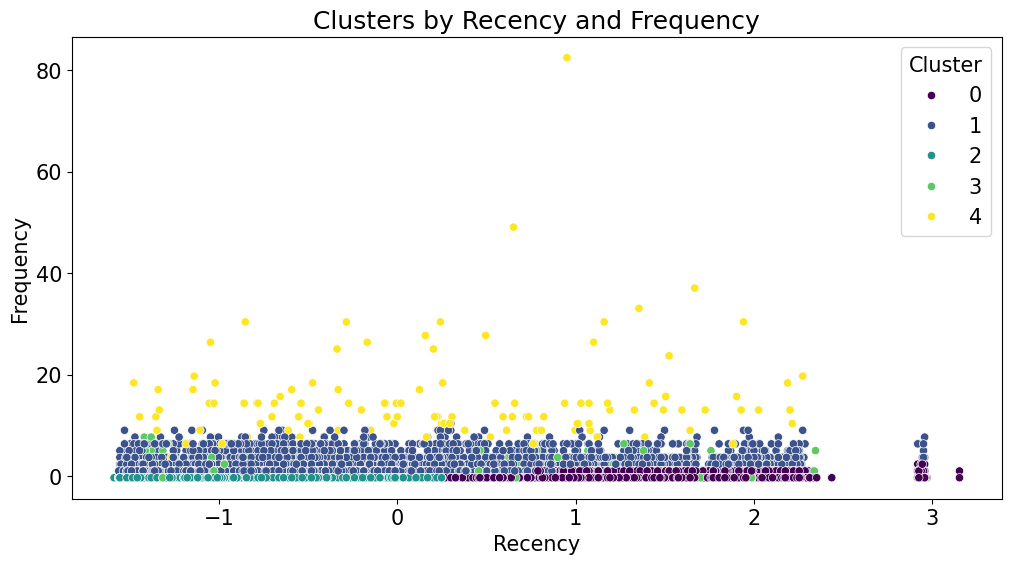

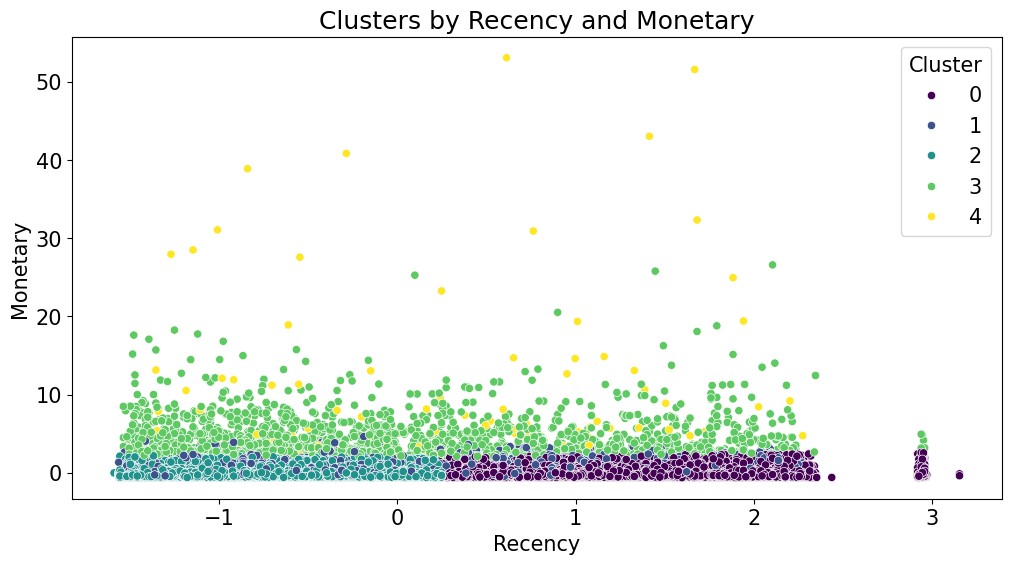

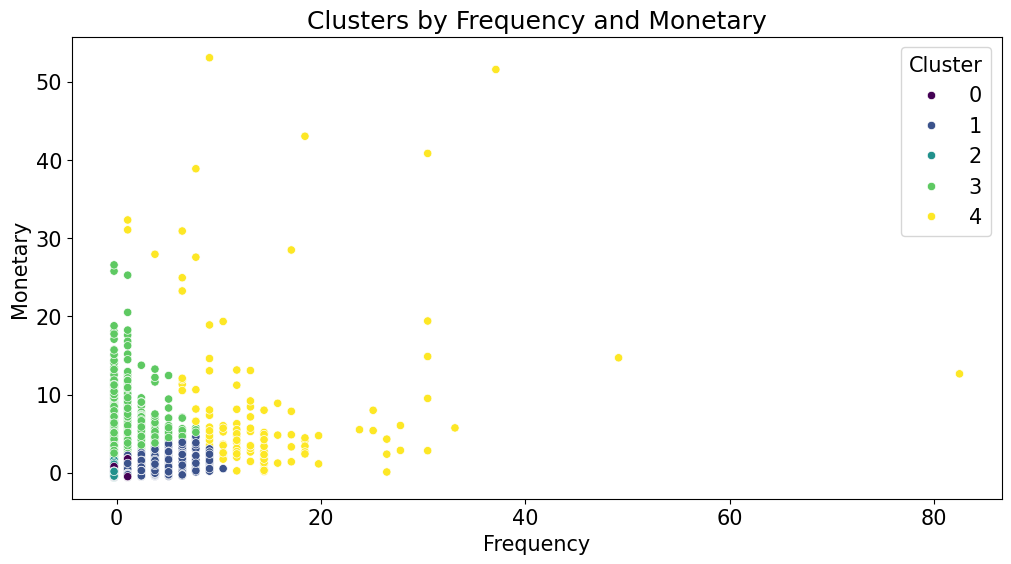

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Clusters by Recency and Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Clusters by Recency and Monetary')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Clusters by Frequency and Monetary')
plt.show()
